In [1]:
from graphviz import Digraph, Graph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

from tqdm import tqdm
from numpy import mean

from analysis import *
from joblib import Parallel, delayed

base_dir = '/Users/dhruvlaad/IIT/DDP/data/'
# base_dir = 'D:/IIT/DDP/data/'
label_info_file = base_dir + 'analysis/label_info.pkl'
stats_file = base_dir + 'analysis/stats.pkl'

In [2]:
import time
start = time.perf_counter()
behaviour_stats = all_behaviour_info_for_all_strains(label_info_file, max_label=19)
print(time.perf_counter() - start)
for key in BEHAVIOUR_LABELS.keys():
    nb_max = max(behaviour_stats[key]['No. of Bouts'])
    print(f'{key}: {nb_max}')
# with open(stats_file, 'rb') as f:
#     behaviour_stats = joblib.load(f)

{'Groom': {'TD': 200.43333333333334, 'ABL': 9.110606060606061, 'NB': 22}, 'Run': {'TD': 3.6666666666666665, 'ABL': 0.611111111111111, 'NB': 6}, 'Walk': {'TD': 0.43333333333333335, 'ABL': 0.43333333333333335, 'NB': 1}, 'CW-Turn': {'TD': 140.13333333333333, 'ABL': 0.7828677839851024, 'NB': 179}, 'CCW-Turn': {'TD': 164.83333333333334, 'ABL': 0.7424924924924924, 'NB': 222}, 'Point': {'TD': 0.5333333333333333, 'ABL': 0.5333333333333333, 'NB': 1}, 'Rear': {'TD': 6.7, 'ABL': 0.5583333333333333, 'NB': 12}, 'N/A': {'TD': 0.0, 'ABL': 0.0, 'NB': 0}, 'Strain': 'C3H/HeJ', 'Sex': 'C3H/HeJ'}


TypeError: 'ApplyResult' object is not subscriptable

In [16]:
# behaviour_stats.keys()
key = 'Run'
plot_dir = base_dir + 'analysis/plots'
stats = behaviour_stats[key]
info = pd.DataFrame.from_dict(stats)

In [17]:
info_ = info.copy(deep=True)
info_['Total Duration'] = info['Total Duration']/60
info_['Average Bout Length'] = info['Average Bout Length']

# plotting routines

In [18]:
def sort_info_df(info, metric):
    N = info.shape[0]
    strains = {}
    for strain in info['Strain']:
        strains[strain] = []
        
    for i in range(N):
        data = info.iloc[i]
        strains[data['Strain']].append(data[metric])
    
    for key, value in strains.items():
        strains[key] = sum(value)/len(value)
    
    strains = dict(sorted(strains.items(), key=lambda item: item[1]))
    return strains.keys()

def plot_behaviour_metric(info, metric, order, ylabel=None):        
    ylabel = metric if ylabel is None else ylabel
    
    fig = plt.figure(figsize=(10, 100))
    g = sns.catplot(x='Strain', y=metric, data=info, hue='Sex', jitter=False, legend=False, order=order, ci=0.95)
    ax = g.axes[0,0]
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(None, fontsize=12)
    ax.legend(loc='upper left')
    plt.gcf().set_size_inches(15, 2.2)
    return fig, ax

<Figure size 720x7200 with 0 Axes>

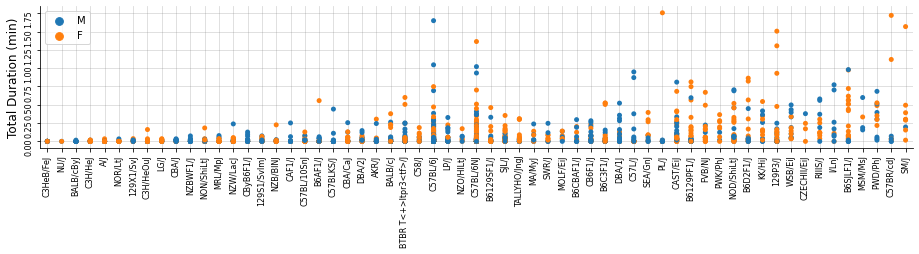

In [19]:
strains = list(sort_info_df(info_, 'Total Duration'))
fig, ax = plot_behaviour_metric(info_, 'Total Duration', strains, 'Total Duration (min)', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

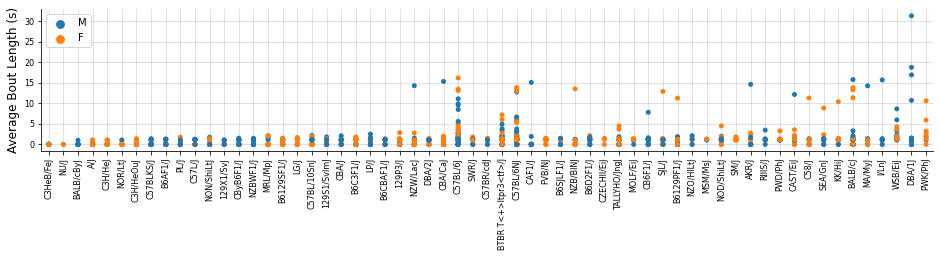

In [20]:
strains = list(sort_info_df(info_, 'Average Bout Length'))
fig, ax = plot_behaviour_metric(info_, 'Average Bout Length', strains, 'Average Bout Length (s)', )
# ax.set_ylim([1, 2])
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

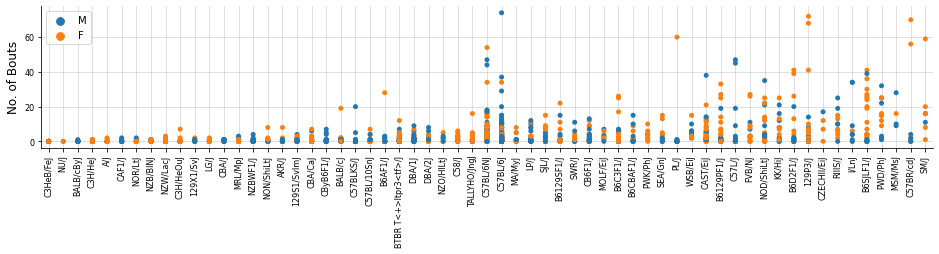

In [21]:
strains = list(sort_info_df(info_, 'No. of Bouts'))
fig, ax = plot_behaviour_metric(info_, 'No. of Bouts', strains, 'No. of Bouts', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

In [275]:
# plot behaviour distribution for all data
import numpy as np
from analysis import *
from BSOID.bsoid import BSOID

prop = 100 * calculate_behaviour_usage(label_info_file, max_label=19)

labels = [None for _ in range(len(prop))]
for key, val in BEHAVIOUR_LABELS.items():
    if len(val) > 1:
        for i, idx in enumerate(val):
            labels[idx] = f'{key} #{i}'
    else:
        labels[val[0]] = key
fig = plt.figure(figsize=(12,9))
ax = sns.barplot(x=np.arange(len(prop)), y=prop)
ax.set_xticklabels(labels)
ax.set_ylabel('% samples of behaviour')
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
fig.savefig(f'{plot_dir}/prop.png')
fig.show()

/Users/dhruvlaad/anaconda3/envs/ddp/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


ModuleNotFoundError: No module named 'psutil'

# Show proportion of behaviour used for each strain
----

In [ ]:
usage_data = behaviour_usage_across_strains(stats_file, min_threshold=0.01)
usage_data = usage_data.pivot_table(index='Behaviour', columns='Strain', values='Usage')

ax = sns.heatmap(usage_data, xticklabels=True, yticklabels=True, cmap='cubehelix')
plt.gcf().set_size_inches(15.5, 4)
plt.savefig(f'{plot_dir}/usage.png')
plt.show() 

# Plot transition network

In [249]:
def tnet_from_tmat(tmat, behaviour_usage, max_edges):
    node_szs = behaviour_usage
    color = '#0069ffff'
#     color='#0000005a'
    bins = [0, 0.01, 0.025]
    edge_sz = [0, 0.1, 1]
    weights = {edge_sz[0]: str(0), edge_sz[1]: str(10), edge_sz[2]: str(100)}
    lengths = {edge_sz[0]: str(10), edge_sz[1]: str(2), edge_sz[2]: str(1)}
    
    graph_props = {'size': '5,5!', 'dpi':'200', 'splines':'line'}
    G = Digraph(format='png', engine='neato', graph_attr=graph_props)
    
    node_wts = []
    for i in range(tmat.shape[0]):
        for j in range(tmat.shape[0]):

            node_wts.append([tmat[i,j], i, j])
    node_wts.sort(key=lambda x: x[0])
    
    
    return G

def bin_value(bins, val):
    for i in range(len(bins)):
        
def get_usage_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
    usage_data = Parallel(n_jobs=-1)(delayed(behaviour_proportion)(labs, max_label) for labs in labels)
#     usage_data = np.vstack([behaviour_proportion(labs, max_label) for labs in labels])
    usage_data = np.vstack(usage_data)
    usage_data = usage_data.sum(axis=0)/usage_data.shape[0]
    return usage_data
    
def get_tmat_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
#     tmat_data = [transition_matrix_from_assay(labs, max_label) for labs in labels]
    tmat_data = Parallel(n_jobs=-1)(delayed(transition_matrix_from_assay)(labs, max_label) for labs in labels)
            
    tmat = tmat_data[0]
    for i in range(1, len(tmat_data)):
        tmat += tmat_data[i]
    
    tmat = tmat / len(tmat_data)
    return tmat

In [ ]:
tmat = get_tmat_for_strain(label_info_file, max_label=19)
usage = get_usage_for_strain(label_info_file, max_label=19)

In [250]:
G = tnet_from_tmat(tmat, usage, 6)
G.view()

'Graph.gv.png'

In [186]:
bins = [0, 0.1, 0.3]
edge_sz = [0, 0.1, 1]
weights = {edge_sz[0]: str(0), edge_sz[1]: str(1), edge_sz[2]: str(10)}
n_lab = tmat.shape[0]
wmat = np.zeros_like(tmat)
for i in range(n_lab):
    for j in range(len(bins)):
        if j == len(bins) - 1:
            idx = np.where(tmat[i] >= bins[j])
        else:
            idx = np.where((tmat[i] >= bins[j]) & (tmat[i] < bins[j+1]))
        wmat[i,idx] = edge_sz[j]

In [22]:

for key in BEHAVIOUR_LABELS.keys():
    nb_max = max(behaviour_stats[key]['No. of Bouts'])
    print(f'{key}: {nb_max}')

Groom: 243
Run: 74
Walk: 1291
CW-Turn: 1047
CCW-Turn: 932
Point: 3131
Rear: 4480
N/A: 5171
